#### 데이터 전처리

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 평균0표준편차1, 0과 1사이 값으로 조정
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# 모델 저장하고 불러오는 함수
import pickle
def save_model(model_name, model):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
    
def load_model(model_name):
    with open(model_name, 'rb') as f:
        mod = pickle.load(f)
    return mod

def timeCos(x): # 시간대 코사인 변환(24시와 5시의 시간적 차이를 줄이기 위해서)
    return np.cos(int(x) * np.pi / 12.0)

def rain(x):
    if x > 3:
        t = 4
    elif x > 2:
        t = 3
    elif x > 1:
        t = 2
    elif x > 0:
        t = 1
    else:
        t = 0
    return t

In [3]:
df_2023 = pd.read_csv('learningdata/testdata_2023.csv',encoding='utf-8')
df_2022 = pd.read_csv('learningdata/testdata_2022.csv',encoding='utf-8')
df_2021 = pd.read_csv('learningdata/testdata_2021.csv',encoding='utf-8')

In [4]:
df_2022[['하차인원','강수량(mm)','최저기온','최고기온','시간','미세먼지(pm10)']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
하차인원,1791720.0,785.533197,1058.593724,0.0,254.0,488.0,904.0,18809.0
강수량(mm),1791720.0,4.863623,18.630344,0.0,0.0,0.0,0.3,176.2
최저기온,1786824.0,9.207638,11.242889,-13.7,0.3,10.4,18.7,27.4
최고기온,1791720.0,18.078491,10.813109,-8.6,9.1,20.2,27.4,36.1
시간,1791720.0,14.500000,5.188129,6.0,10.0,14.5,19.0,23.0
미세먼지(pm10),1791720.0,32.539994,19.421998,3.0,21.0,29.0,40.0,269.0


/opt/anaconda3/envs/bus/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


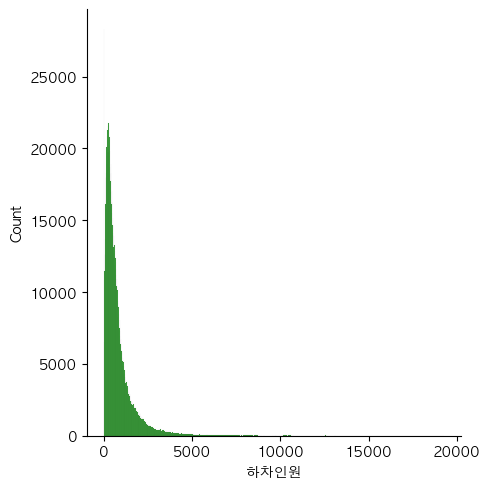

In [5]:
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
sns.displot(df_2023['하차인원'], color='green')

##### 하차인원 로그 유무와 강수량 로그 유무에 따른 성능 비교

In [9]:
# 하차인원에 로그를 취한 값과 안한 값 예측 정확도 비교 and 강수량 로그 유무 비교
def testLog(data):
	X_train, X_test, y_train, y_test = train_test_split(data.drop('하차인원', axis=1), data['하차인원'], test_size=0.2, random_state=20)
	best_rf_model = RandomForestRegressor(random_state=20, max_depth=20, n_estimators=600, min_samples_leaf=8, min_samples_split=8)
	best_rf_model.fit(X_train, y_train)
	# 테스트 데이터로 성능 평가
	rf_pred = best_rf_model.predict(X_test)
	mse = mean_squared_error(y_test, rf_pred)
	mae = mean_absolute_error(y_test, rf_pred)
	r2 = r2_score(y_test,rf_pred)
	print(f"Test MSE: {mse}, Test MAE: {mae}, R2 score: {r2}")

In [7]:
# 기본 모델 학습 결과
def adjustDf(temp_df):
	temp_df['시간'] = temp_df['시간'].apply(timeCos)
    # 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
	temp_df['일시'] = pd.to_datetime(temp_df['일시'])
	temp_df['day_of_year'] = temp_df['일시'].dt.dayofyear
	temp_df['day_of_year_cos'] = np.cos(2 * np.pi * temp_df['day_of_year'] / 365)
	temp_df = temp_df.drop(['일시','day_of_year','역명'],axis=1)
	return temp_df
df_2023_01 = df_2023[df_2023['일시'].str.startswith('2023-01')].copy()
df_2023_01 = adjustDf(df_2023_01)
testLog(df_2023_01)

Test MSE: 494171.804166706, Test MAE: 273.2445966461952, R2 score: 0.6022359239529198


In [8]:
# 하차인원 log 적용한 학습결과
# 기본 모델 학습 결과
def adjustDf(temp_df):
	temp_df['시간'] = temp_df['시간'].apply(timeCos)
    # 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
	temp_df['일시'] = pd.to_datetime(temp_df['일시'])
	temp_df['day_of_year'] = temp_df['일시'].dt.dayofyear
	temp_df['day_of_year_cos'] = np.cos(2 * np.pi * temp_df['day_of_year'] / 365)
	temp_df = temp_df.drop(['일시','day_of_year','역명'],axis=1)
	temp_df['하차인원'] = temp_df['하차인원'].apply(np.log1p)
	return temp_df
df_2023_01 = df_2023[df_2023['일시'].str.startswith('2023-01')].copy()
df_2023_01 = adjustDf(df_2023_01)
testLog(df_2023_01)

Test MSE: 0.24262453985608567, Test MAE: 0.34233046652976146, R2 score: 0.7724066950876384


In [9]:
# 하차인원 log + 강수량 log 적용한 학습결과
# 기본 모델 학습 결과
def adjustDf(temp_df):
	temp_df['시간'] = temp_df['시간'].apply(timeCos)
    # 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
	temp_df['일시'] = pd.to_datetime(temp_df['일시'])
	temp_df['day_of_year'] = temp_df['일시'].dt.dayofyear
	temp_df['day_of_year_cos'] = np.cos(2 * np.pi * temp_df['day_of_year'] / 365)
	temp_df = temp_df.drop(['일시','day_of_year','역명'],axis=1)
	temp_df['하차인원'] = temp_df['하차인원'].apply(np.log1p)
	temp_df['강수량(mm)'] = temp_df['강수량(mm)'].apply(np.log1p)
	temp_df['강수량(mm)'] = temp_df['강수량(mm)'].apply(rain)
	return temp_df
df_2023_01 = df_2023[df_2023['일시'].str.startswith('2023-01')].copy()
df_2023_01 = adjustDf(df_2023_01)
testLog(df_2023_01)

Test MSE: 0.2426137314431186, Test MAE: 0.3423229947544007, R2 score: 0.7724168338907021


In [10]:
# 시간 코사인 적용 안함
# 기본 모델 학습 결과
def adjustDf(temp_df):
	#temp_df['시간'] = temp_df['시간'].apply(timeCos)
    # 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
	temp_df['일시'] = pd.to_datetime(temp_df['일시'])
	temp_df['day_of_year'] = temp_df['일시'].dt.dayofyear
	temp_df['day_of_year_cos'] = np.cos(2 * np.pi * temp_df['day_of_year'] / 365)
	temp_df = temp_df.drop(['일시','day_of_year','역명'],axis=1)
	temp_df['하차인원'] = temp_df['하차인원'].apply(np.log1p)
	return temp_df
df_2023_01 = df_2023[df_2023['일시'].str.startswith('2023-01')].copy()
df_2023_01 = adjustDf(df_2023_01)
testLog(df_2023_01)

Test MSE: 0.0736423536411812, Test MAE: 0.17717927147723078, R2 score: 0.9309199858486576


##### 데이터 전처리 & 시각화 & 분석

In [6]:
def adjustDf(temp_df):
    # 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
	temp_df['일시'] = pd.to_datetime(temp_df['일시'])
	temp_df['day_of_year'] = temp_df['일시'].dt.dayofyear
	temp_df['day_of_year_cos'] = np.cos(2 * np.pi * temp_df['day_of_year'] / 365)
	temp_df = temp_df.drop(['일시','day_of_year','역명'],axis=1)
	temp_df['하차인원'] = temp_df['하차인원'].apply(np.log1p)
	return temp_df

In [7]:
df = df_2022.copy()
df = adjustDf(df)

/opt/anaconda3/envs/bus/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


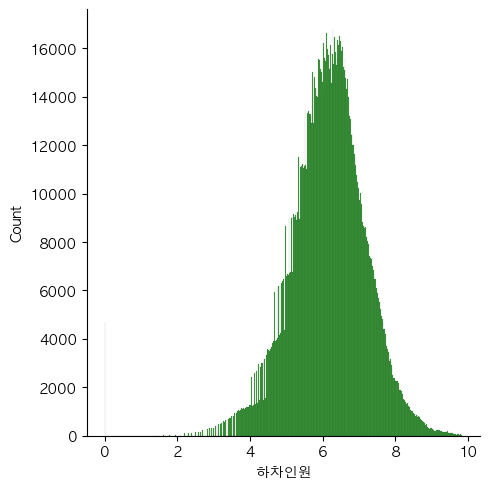

In [8]:
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
sns.displot(df['하차인원'], color='green')

In [9]:
df[['하차인원','강수량(mm)','최저기온','최고기온','시간','day_of_year_cos','미세먼지(pm10)']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
하차인원,1791720.0,6.161834,1.038292,0.000000,5.541264,6.192362,6.807935,9.842144
강수량(mm),1791720.0,4.863623,18.630344,0.000000,0.000000,0.000000,0.300000,176.200000
최저기온,1786824.0,9.207638,11.242889,-13.700000,0.300000,10.400000,18.700000,27.400000
최고기온,1791720.0,18.078491,10.813109,-8.600000,9.100000,20.200000,27.400000,36.100000
시간,1791720.0,14.500000,5.188129,6.000000,10.000000,14.500000,19.000000,23.000000
day_of_year_cos,1791720.0,-0.000011,0.707075,-0.999963,-0.708627,0.004304,0.702527,1.000000
미세먼지(pm10),1791720.0,32.539994,19.421998,3.000000,21.000000,29.000000,40.000000,269.000000


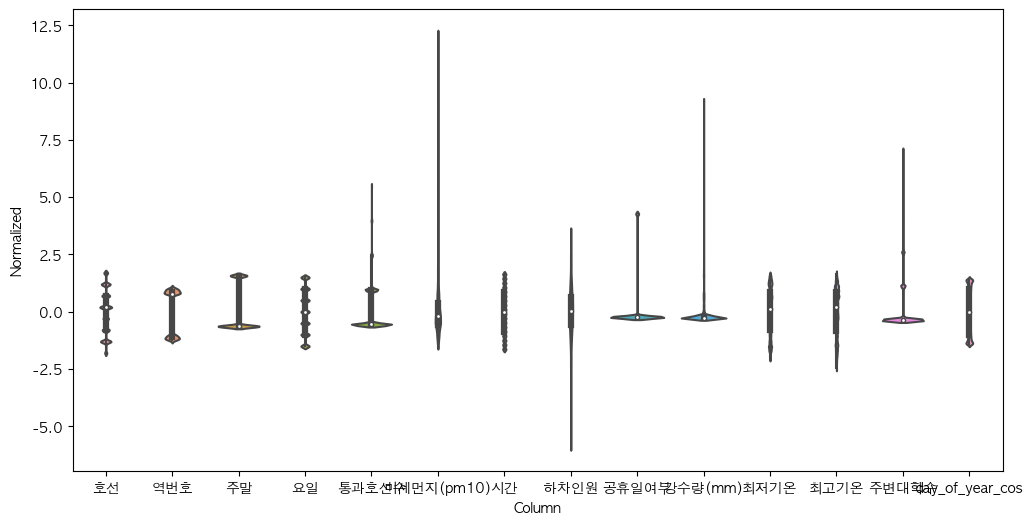

In [10]:
train_mean = df.mean()
train_std = df.std()
train_df = (df - train_mean) / train_std
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=0)

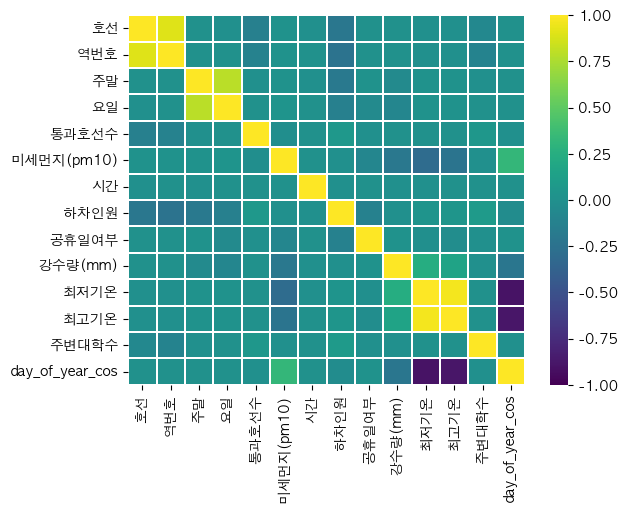

In [11]:
sns.heatmap(df.corr(),vmin=-1,vmax=1,linewidths=0.2,cmap='viridis')
plt.show()

In [12]:
# 2022년 1월 데이터를 test data로 사용
test_2023 = df_2023[df_2023['일시'].str.startswith('2023-01')].copy()
test_2023 = adjustDf(test_2023)

In [13]:
test_2023.head(5)

,호선,역번호,주말,요일,통과호선수,미세먼지(pm10),시간,하차인원,공휴일여부,강수량(mm),최저기온,최고기온,주변대학수,day_of_year_cos
0,1,150,1,6,4,54.0,6,6.456770,1,0.0,-4.3,3.8,0,0.999852
1,1,151,1,6,2,54.0,6,5.513429,1,0.0,-4.3,3.8,0,0.999852
2,1,152,1,6,1,53.0,6,5.105945,1,0.0,-4.3,3.8,0,0.999852
3,1,153,1,6,3,53.0,6,4.779123,1,0.0,-4.3,3.8,0,0.999852
4,1,154,1,6,1,53.0,6,4.442651,1,0.0,-4.3,3.8,0,0.999852


In [14]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop('하차인원', axis=1), df['하차인원'], test_size=0.2, random_state=20)

X_train = df.drop('하차인원', axis=1)
y_train = df['하차인원']
X_test = test_2023.drop('하차인원', axis=1)
y_test = test_2023['하차인원']

In [15]:
print(X_train.shape)
print(X_test.shape)

(1791720, 13)
(151776, 13)


#### 학습 Model 및 예측

##### Keras Sequential model

In [17]:
keras_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

keras_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience = 5)
history = keras_model.fit(X_train, y_train, epochs=50, batch_size=15, validation_split=0.25, callbacks=[early_stopping])
keras_model.evaluate(X_test,y_test)

Epoch 1/50


/opt/anaconda3/envs/bus/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6071/6071 ━━━━━━━━━━━━━━━━━━━━ 3s 361us/step - loss: 410.3127 - mae: 5.4248 - val_loss: 1.2087 - val_mae: 0.8784
Epoch 2/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 348us/step - loss: 1.2734 - mae: 0.8786 - val_loss: 1.0666 - val_mae: 0.8214
Epoch 3/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step - loss: 0.9791 - mae: 0.7726 - val_loss: 1.0417 - val_mae: 0.8027
Epoch 4/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step - loss: 1.0415 - mae: 0.8016 - val_loss: 1.0452 - val_mae: 0.8046
Epoch 5/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - loss: 1.0476 - mae: 0.8024 - val_loss: 1.0416 - val_mae: 0.8022
Epoch 6/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step - loss: 1.0480 - mae: 0.8044 - val_loss: 1.0430 - val_mae: 0.8035
Epoch 7/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step - loss: 1.0524 - mae: 0.8054 - val_loss: 1.0414 - val_mae: 0.8023
Epoch 8/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step - loss: 1.0462 - mae: 0.8034 - val_loss: 1.0432 - val_mae: 0.8025
Epoch 9/50
6071/6071 ━━━━━━━━━━━━

[1.0663435459136963, 0.8108019828796387]

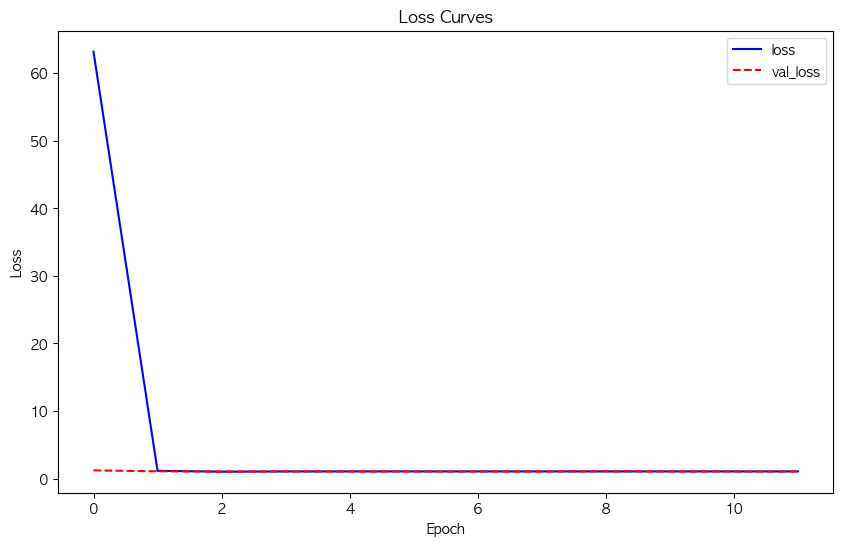

In [18]:
# 회귀 모델 학습 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

949/949 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


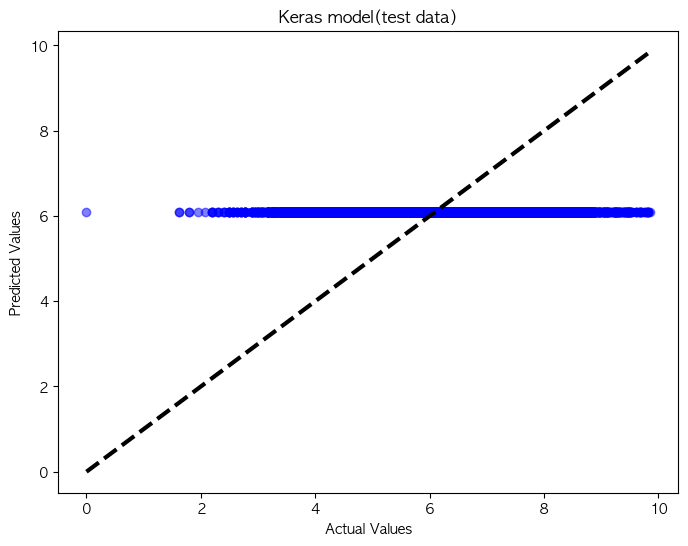

In [19]:
keras_pred = keras_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, keras_pred, alpha=0.5, c='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Keras model(test data)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

##### SGDRegressor model

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [32]:
'''
param_grid = {
#	'alpha' : [0.0001,0.001,0.01,0.1],
#	'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
#	'eta0' : [0.01,0.1,1],
#	'penalty' : ['l2', 'l1', 'elasticnet'],
	'max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(SGDRegressor(random_state=20, alpha = 0.001, eta0= 0.01, learning_rate='optimal', penalty='l2', max_iter=1000), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled,y_train)
print("Best parameters: ",grid_search.best_params_)
'''
# SGDRegressor(random_state=20, alpha = 0.001, eta0= 0.01, learning_rate='optimal', penalty='l2', max_iter=1000)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................max_iter=1000; total time=   0.1s
[CV] END ......................................max_iter=1000; total time=   0.1s
[CV] END ......................................max_iter=1000; total time=   0.1s
[CV] END ......................................max_iter=1000; total time=   0.1s
[CV] END ......................................max_iter=1000; total time=   0.1s
[CV] END ......................................max_iter=2000; total time=   0.1s
[CV] END ......................................max_iter=2000; total time=   0.1s
[CV] END ......................................max_iter=2000; total time=   0.1s
[CV] END ......................................max_iter=2000; total time=   0.1s
[CV] END ......................................max_iter=2000; total time=   0.1s
[CV] END ......................................max_iter=3000; total time=   0.1s
[CV] END ......................................ma

In [21]:
best_sgd_regressor = SGDRegressor(random_state=20, alpha = 0.001, eta0= 0.01, learning_rate='optimal', penalty='l2', max_iter=1000)
best_sgd_regressor.fit(X_train_scaled,y_train)

SGDRegressor(alpha=0.001, learning_rate='optimal', random_state=20)

In [22]:
# 테스트 데이터로 성능 평가
sgd_pred = best_sgd_regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, sgd_pred)
mae = mean_absolute_error(y_test, sgd_pred)
r2 = r2_score(y_test,sgd_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}, R2 score: {r2}")

Test MSE: 0.8612917208928373, Test MAE: 0.7219792689904367, R2 score: 0.19206758983271344


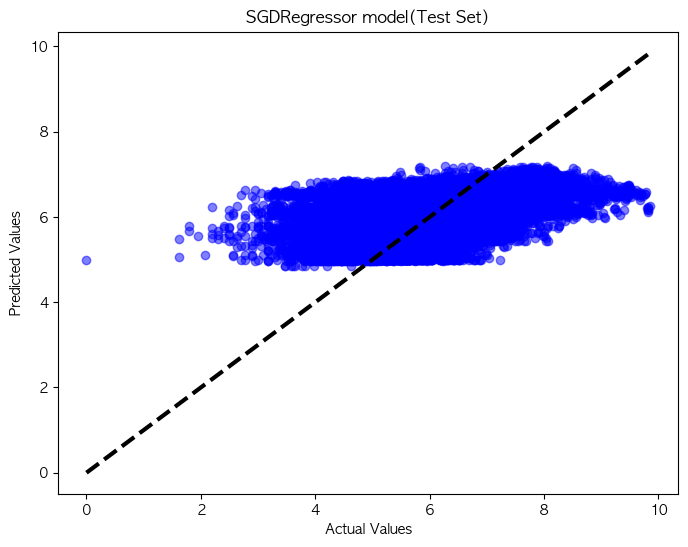

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, sgd_pred, alpha=0.5, c='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SGDRegressor model(Test Set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

##### Sklearn model

In [42]:
# 기본 모델 학습 예측 결과
best_rf_model = RandomForestRegressor(random_state=20)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=20)

In [43]:
# 테스트 데이터로 성능 평가
rf_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test,rf_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}, R2 score: {r2}")

Test MSE: 0.17157169516548446, Test MAE: 0.21349045135690523, R2 score: 0.8540657357104964


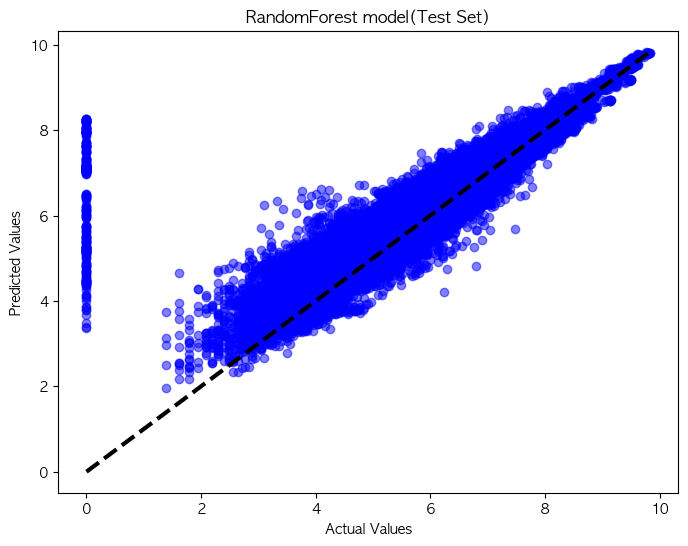

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, c='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest model(Test Set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

##### 랜덤 포레스트 하이퍼 파라미터 튜닝 및 학습 예측

In [50]:
# 하이퍼 파라미터 튜닝
'''
param_grid = {
    'max_depth' : [8,16,32],
    'n_estimators' : [100,200,300]
    #'min_samples_leaf' : [2, 4, 8],
    #'min_samples_split' : [2, 8, 16]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=20, min_samples_leaf=2, min_samples_split=2), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
'''

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=8, n_estimators=100; total time=   8.5s
[CV] END ......................max_depth=8, n_estimators=100; total time=   8.1s
[CV] END ......................max_depth=8, n_estimators=100; total time=   8.3s
[CV] END ......................max_depth=8, n_estimators=200; total time=  16.9s
[CV] END ......................max_depth=8, n_estimators=200; total time=  16.3s
[CV] END ......................max_depth=8, n_estimators=200; total time=  16.6s
[CV] END ......................max_depth=8, n_estimators=300; total time=  25.3s
[CV] END ......................max_depth=8, n_estimators=300; total time=  24.4s
[CV] END ......................max_depth=8, n_estimators=300; total time=  25.0s
[CV] END .....................max_depth=16, n_estimators=100; total time=  15.9s
[CV] END .....................max_depth=16, n_estimators=100; total time=  15.3s
[CV] END .....................max_depth=16, n_est

In [16]:
best_rf_model = RandomForestRegressor(random_state=20, max_depth=32, n_estimators=100, min_samples_leaf=2, min_samples_split=2)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=32, min_samples_leaf=2, random_state=20)

In [ ]:
# 모델 파일 저장
save_model('models/2022_rf_model', best_rf_model)

In [17]:
# 테스트 데이터로 성능 평가
rf_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test,rf_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}, R2 score: {r2}")

Test MSE: 0.05957760338724627, Test MAE: 0.1620549057780846, R2 score: 0.9431899449888105


##### Total predict graph

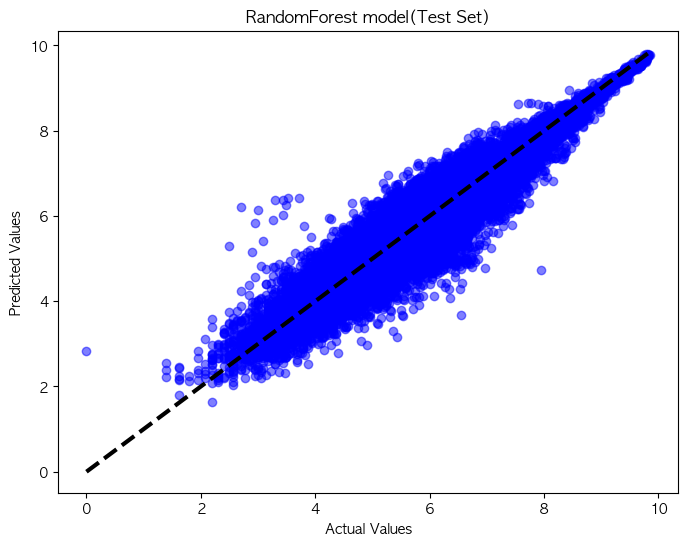

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, c='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest model(Test Set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()